# Progress Check 2

**MODEL BUILDING & EVALUATION**

**Install required packages**

In [14]:
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 1.3/376.0 MB 3.2 MB/s eta 0:01:58
   ---------------------------------------- 2.6/376.0 MB 4.4 MB/s eta 0:01:25
   ---------------------------------------- 2.6/376.0 MB 4.4 MB/s eta 0:01:25
   ---------------------------------------- 2.6/376.0 MB 4.4 MB/s eta 0:01:25
   -----------------------------------

**Data Preparation for modelling**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

# Load the previously prepared data
df_1 = pd.read_csv("df_1_cleaned_assignment_data.csv")

# Prepare features for modeling
df_1['listed_date'] = pd.to_datetime(df_1['listed_date'])  # Keep for reference but avoid redundant splitting
# Use days_on_market directly as the temporal feature, no need for listed_month, listed_year, listed_day
numeric_features = ['listed_price', 'days_on_market', 'number_of_beds', 
                   'number_of_baths', 'number_of_parks', 'property_size']

# Get dummy columns
dummy_columns = [col for col in df_1.columns if col.startswith('property_classification_') 
                or col.startswith('property_sub_classification_')]

# Create binary target variable
df_1['target'] = df_1['price_outcome'].apply(lambda x: 1 if x == 'Higher' else 0)

# Create feature sets
X_features = df_1[numeric_features + dummy_columns]
y = df_1['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Random Forest Model**

In [2]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", cv_scores_rf)
print("Average CV Accuracy:", cv_scores_rf.mean())

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_features.columns,
    'Importance': rf_model.feature_importances_
})
top_features = feature_importance.sort_values('Importance', ascending=False).head(5)
print("Top 5 Important Features:")
print(top_features)

Random Forest Cross-Validation Accuracy Scores: [0.788 0.787 0.814 0.794 0.822]
Average CV Accuracy: 0.8009999999999999
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       465
           1       0.85      0.90      0.87       786

    accuracy                           0.84      1251
   macro avg       0.83      0.82      0.82      1251
weighted avg       0.83      0.84      0.83      1251

Top 5 Important Features:
           Feature  Importance
0     listed_price    0.317855
1   days_on_market    0.310753
5    property_size    0.207916
4  number_of_parks    0.058905
2   number_of_beds    0.045817


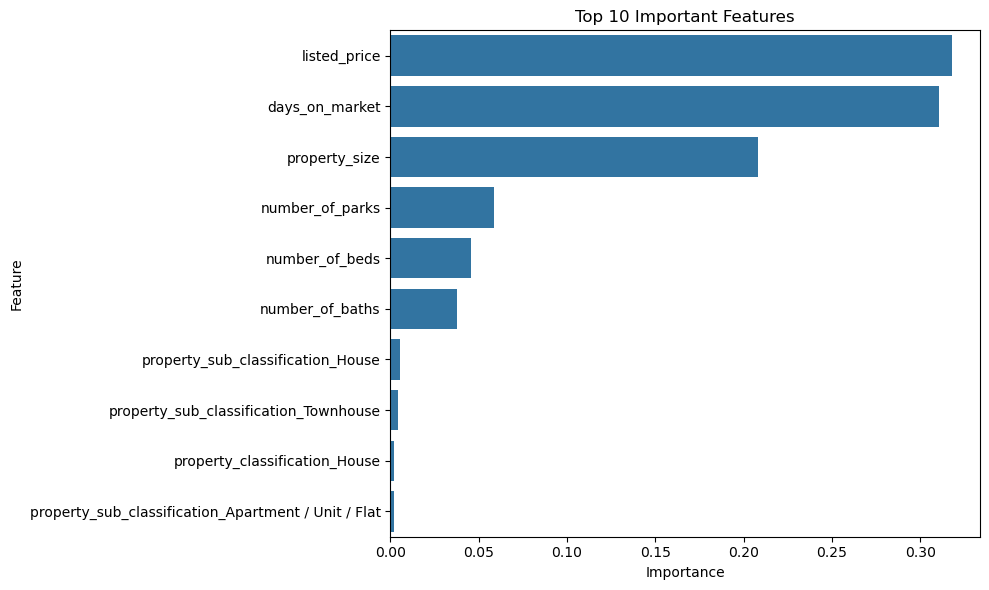

In [3]:
# Visualize feature importance
feature_importance = pd.DataFrame({
    'Feature': X_features.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 10 Important Features')
plt.tight_layout()
plt.show()

**RNN(Recurrent Neural Network) Model**

In [4]:
# Reshape data for RNN (adding a time dimension, assuming sequences of length 1 for each feature)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build RNN model
input_layer = Input(shape=(1, X_train_rnn.shape[2]))
lstm_layer = LSTM(50, return_sequences=False)(input_layer)
dropout1 = Dropout(0.2)(lstm_layer)
dense_layer = Dense(1, activation='sigmoid')(dropout1)

rnn_model = Model(inputs=input_layer, outputs=dense_layer)
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Train RNN model
rnn_model.fit(X_train_rnn, y_train, 
              epochs=10, 
              batch_size=32, 
              verbose=1,
              validation_split=0.1)

# Cross-validation for RNN (approximated with k-fold on training data)
# Note: Keras models require custom cross-validation logic; here we use a simple approximation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rnn = []
for train_idx, val_idx in kfold.split(X_train_rnn):
    X_train_fold, X_val_fold = X_train_rnn[train_idx], X_train_rnn[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    rnn_model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    y_val_pred = (rnn_model.predict(X_val_fold) > 0.5).astype(int)
    cv_scores_rnn.append(accuracy_score(y_val_fold, y_val_pred))
print("RNN Cross-Validation Accuracy Scores:", cv_scores_rnn)
print("Average CV Accuracy:", np.mean(cv_scores_rnn))

# Evaluate RNN
y_pred_proba_rnn = rnn_model.predict(X_test_rnn)
y_pred_rnn = (y_pred_proba_rnn > 0.5).astype(int)
print("RNN Classification Report:")
print(classification_report(y_test, y_pred_rnn))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5795 - loss: 0.6755 - val_accuracy: 0.6520 - val_loss: 0.6339
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6386 - loss: 0.6380 - val_accuracy: 0.6600 - val_loss: 0.6195
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6567 - loss: 0.6186 - val_accuracy: 0.6760 - val_loss: 0.6137
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6413 - loss: 0.6253 - val_accuracy: 0.6780 - val_loss: 0.6097
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6534 - loss: 0.6166 - val_accuracy: 0.6840 - val_loss: 0.6074
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6633 - loss: 0.6094 - val_accuracy: 0.6820 - val_loss: 0.6072
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6629 - loss: 0.6074 - val_accuracy: 0.6860 - val_loss: 0.6065
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6502 - loss: 0.6170 - val_accuracy: 

**ANN(Feedforward Neural Network Model)**

In [6]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Create a simple feedforward neural network
input_layer = Input(shape=(X_train_scaled.shape[1],))
hidden1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
output_layer = Dense(1, activation='sigmoid')(dropout2)

ann_model = Model(inputs=input_layer, outputs=output_layer)
ann_model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

# Train ANN model
ann_model.fit(X_train_scaled, y_train, 
              epochs=10, 
              batch_size=32, 
              verbose=1,
              validation_split=0.1)

# Custom cross-validation for ANN
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_ann = []
for train_idx, val_idx in kfold.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Rebuild and compile model for each fold to avoid reusing weights
    input_layer = Input(shape=(X_train_scaled.shape[1],))
    hidden1 = Dense(64, activation='relu')(input_layer)
    dropout1 = Dropout(0.2)(hidden1)
    hidden2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(hidden2)
    output_layer = Dense(1, activation='sigmoid')(dropout2)
    
    fold_model = Model(inputs=input_layer, outputs=output_layer)
    fold_model.compile(loss='binary_crossentropy',
                       optimizer=Adam(learning_rate=0.001),
                       metrics=['accuracy'])
    
    # Train the model on the fold
    fold_model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    
    # Predict and evaluate
    y_val_pred = (fold_model.predict(X_val_fold) > 0.5).astype(int)
    cv_scores_ann.append(accuracy_score(y_val_fold, y_val_pred))

print("ANN Cross-Validation Accuracy Scores:", cv_scores_ann)
print("Average CV Accuracy:", np.mean(cv_scores_ann))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6294 - loss: 0.6778 - val_accuracy: 0.6620 - val_loss: 0.6225
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6262 - loss: 0.6449 - val_accuracy: 0.6680 - val_loss: 0.6139
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6472 - loss: 0.6261 - val_accuracy: 0.6820 - val_loss: 0.6148
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6562 - loss: 0.6185 - val_accuracy: 0.6740 - val_loss: 0.6155
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6600 - loss: 0.6199 - val_accuracy: 0.6740 - val_loss: 0.6131
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6575 - loss: 0.6168 - val_accuracy: 0.6840 - val_loss: 0.6084
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6434 - loss: 0.6235 - val_accuracy: 0.6880 - val_loss: 0.6036
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6609 - loss: 0.6087 - val_accuracy: 0

In [7]:
# Evaluate ANN Model
y_pred_proba_ann = ann_model.predict(X_test_scaled)
y_pred_ann = (y_pred_proba_ann > 0.5).astype(int)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_ann))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.27      0.37       465
           1       0.68      0.90      0.77       786

    accuracy                           0.67      1251
   macro avg       0.65      0.58      0.57      1251
weighted avg       0.65      0.67      0.62      1251



**Compare Models and Select Best**

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


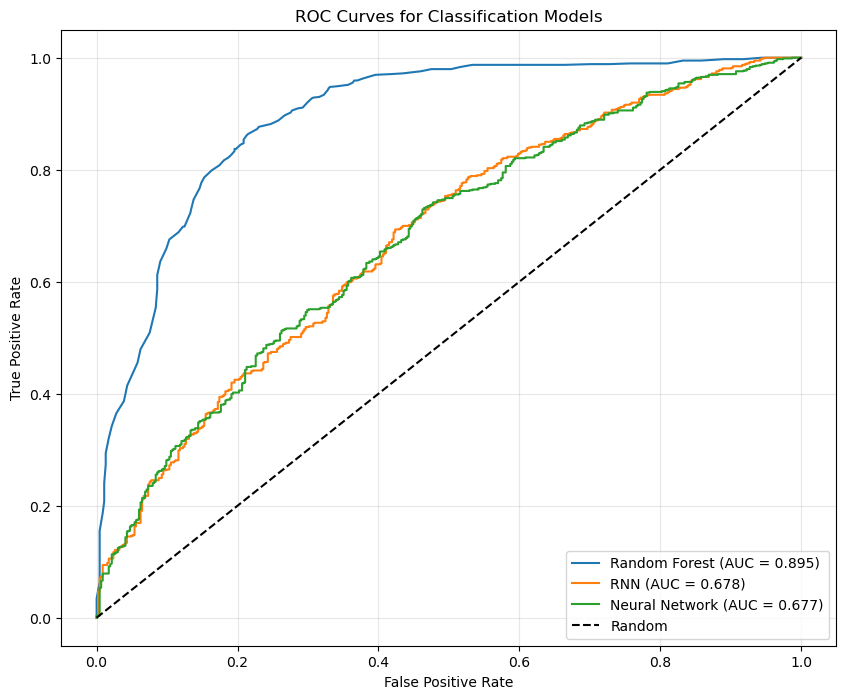

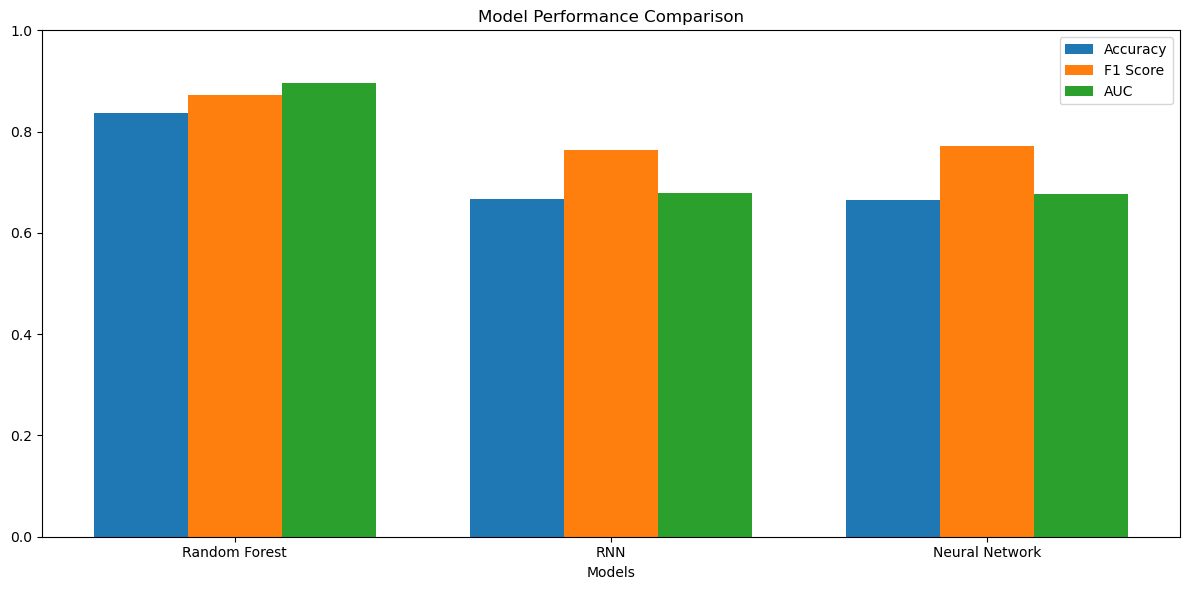

The best performing model is: Random Forest
Best model metrics:
- Accuracy: 0.8361
- F1 Score: 0.8731
- AUC: 0.8951


In [8]:
# Compare model performances
models = ['Random Forest', 'RNN', 'Neural Network']
accuracy_scores = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_rnn.flatten()),
    accuracy_score(y_test, y_pred_ann.flatten())
]
f1_scores = [
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rnn.flatten()),
    f1_score(y_test, y_pred_ann.flatten())
]

# Get probabilities for ROC curves
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_prob_rnn = rnn_model.predict(X_test_rnn).flatten()
y_prob_ann = ann_model.predict(X_test_scaled).flatten()

# Calculate ROC curve and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_prob_rnn)
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)

auc_rf = auc(fpr_rf, tpr_rf)
auc_rnn = auc(fpr_rnn, tpr_rnn)
auc_ann = auc(fpr_ann, tpr_ann)

auc_scores = [auc_rf, auc_rnn, auc_ann]

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_rnn, tpr_rnn, label=f'RNN (AUC = {auc_rnn:.3f})')
plt.plot(fpr_ann, tpr_ann, label=f'Neural Network (AUC = {auc_ann:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Visualize performance metrics comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, accuracy_scores, width, label='Accuracy')
plt.bar(x, f1_scores, width, label='F1 Score')
plt.bar(x + width, auc_scores, width, label='AUC')

plt.xlabel('Models')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Find best model based on AUC and F1 score (balanced assessment)
best_model_index = np.argmax([(f1 + auc)/2 for f1, auc in zip(f1_scores, auc_scores)])
best_model_name = models[best_model_index]
print(f"The best performing model is: {best_model_name}")
print(f"Best model metrics:")
print(f"- Accuracy: {accuracy_scores[best_model_index]:.4f}")
print(f"- F1 Score: {f1_scores[best_model_index]:.4f}")
print(f"- AUC: {auc_scores[best_model_index]:.4f}")